In [1]:
import warnings
warnings.filterwarnings("ignore")

## 分类
#### MNIST

In [2]:
#from sklearn.datasets import fetch_mldata
from sklearn import datasets
mnist = datasets.fetch_mldata('MNIST Original',data_home='/Users/zhen.huaz/work/github/datesets')
#datasets.__file__

/Users/zhen.huaz/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/zhen.huaz/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
X,y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


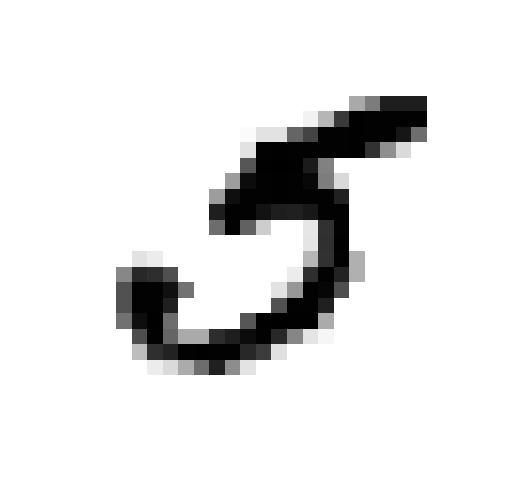

In [4]:
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)

In [7]:
X_train,y_train = X[shuffle_index],y[shuffle_index]

#### 训练二分类

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf  = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ 5.])

#### 交叉验证评估准确性

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([ 0.96965,  0.9475 ,  0.95375])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=np.bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([ 0.90725,  0.9093 ,  0.9124 ])

#### 混淆矩阵

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred

array([False,  True, False, ..., False, False, False], dtype=bool)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)
#返回结果为
# [
#  [TN,FP],
#  [FN,TP]
# ]
# 完美分类器是对角线为0

array([[52854,  1725],
       [  857,  4564]])

<img src="./pic/precision.png" height="100" width="200" align="left"></img><br></br>

<img src="./pic/recall.png" height="100" width="200" align="left"></img><br></br>

<img src="./pic/confusion_matrix.png" height="200" width="300" align="left"></img>

In [16]:
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
print(f1_score(y_train_5,y_train_pred))


0.725711559866
0.841911086515
0.77950469684


<img src="./pic/F1.png" height="300" width="400" align="left"></img>

#### 准确和召回的折中

In [17]:
# decision_function代表的是参数实例到各个类所代表的超平面的距离
y_scores = sgd_clf.decision_function([some_digit])

In [18]:
y_scores

array([[-120336.1375089 , -337585.83865382, -271773.26749841,
        -305670.94317903, -477356.30379632,  144490.98938175,
        -658186.37169005, -173884.17429961, -850336.8028718 ,
        -860775.51161015]])

In [19]:
some_digit.shape

(784,)

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [21]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [22]:
y_scores

array([-520493.86628554,   12094.05703744, -278245.19838173, ...,
        -34992.19912124, -382619.74950705, -270850.78548235])

In [23]:
# 准确性召回性得分
from sklearn.metrics import precision_recall_curve
precision , recall , thresholds = precision_recall_curve(y_train_5,y_scores)

In [24]:
precision

array([ 0.09068099,  0.09066577,  0.09066729, ...,  1.        ,
        1.        ,  1.        ])

In [25]:
def plot_precision_recall_vs_thresholds(precision , recall , thresholds): 
    plt.plot(thresholds,precision[:-1],"b--",label="Precision")
    plt.plot(thresholds,recall[:-1],"g-",label="Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

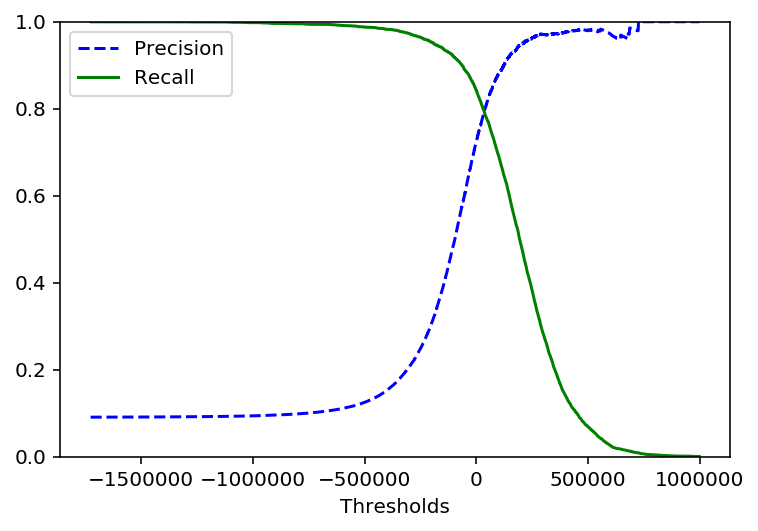

In [26]:
plot_precision_recall_vs_thresholds(precision , recall , thresholds)

#### ROC 曲线

In [27]:
from sklearn.metrics import roc_curve
tpr,fpr,thresholds = roc_curve(y_train_5,y_scores)


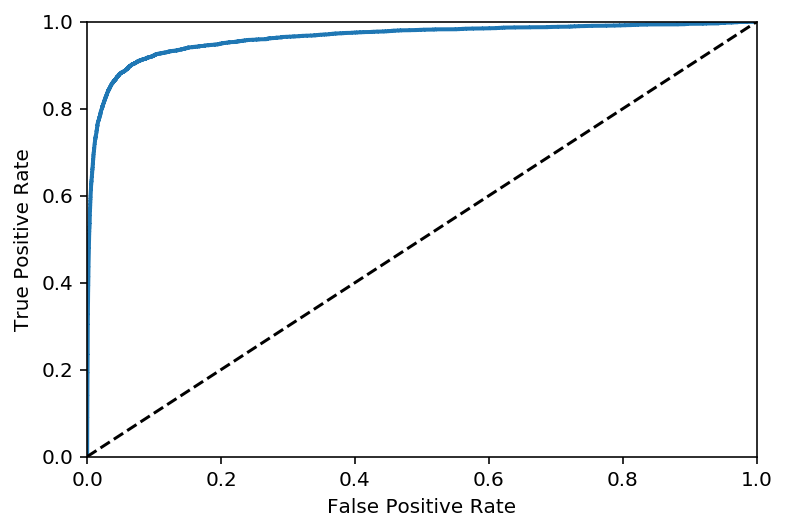

In [28]:
def plot_roc_curve(tpr,fpr,label=None): 
    plt.plot(tpr,fpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_roc_curve(tpr,fpr)

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.963203266712364

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

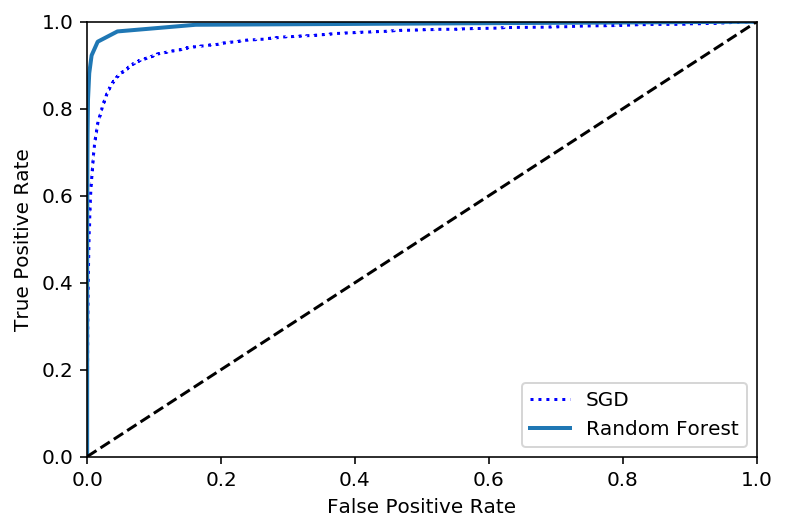

In [31]:
y_scores_forest = y_probas_forest[:,1]
tpr_forest,fpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(tpr,fpr,"b:",label="SGD")
plot_roc_curve(tpr_forest,fpr_forest,label="Random Forest")
plt.legend(loc="bottom right")

In [32]:
y_ = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")
y_

array([[ 1. ,  0. ],
       [ 0.3,  0.7],
       [ 1. ,  0. ],
       ..., 
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       [ 1. ,  0. ]])

In [33]:
forest_clf.verbose



0

In [34]:
roc_auc_score(y_train_5,y_scores_forest)

0.99277165289826508

In [35]:
forest_clf.fit(X=X_train,y=y_train_5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [36]:
y_test_pred = forest_clf.predict(X_test)

In [37]:
print(precision_score(y_test_5,y_test_pred))
print(recall_score(y_test_5,y_test_pred))

0.980211081794
0.832959641256


#### 多分类

In [38]:
# 在多分类中有OvA(训练N【需要的分类个数】个2分类器，使用最高得分)和OvO(每一对进行一次二分类)来实现多分类
# sklearn大部分算法都支持OvA，只有svm只能二分类OvO
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [39]:
some_digit_scores = sgd_clf.decision_function([some_digit]) #返回10个分数
np.argmax(some_digit_scores)

5

In [40]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [41]:
sgd_clf.classes_[5]

5.0

In [42]:
# 如果想强制分类器使用OvO或是OvA策略
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [43]:
len(ovo_clf.estimators_)

45

In [44]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [45]:
# 随机森林本身就是一个多分类器
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.2,  0. ,  0.7,  0. ,  0. ,  0. ,  0. ]])

In [46]:
# 交叉验证
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([ 0.8805239 ,  0.87354368,  0.86057909])

In [47]:
cross_val_score(forest_clf,X_train,y_train,cv=3,scoring='accuracy')

array([ 0.93916217,  0.94014701,  0.94309146])

In [48]:
# 通过标准化后sgd可以提升到90%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([ 0.91061788,  0.90949547,  0.91113667])

#### 错误分析

##### 机器学习的步骤
##### 1.探索数据
##### 2.尝试多种模型
##### 3.选择最好的模型，尽可能使用自动化的GridSearchCV fine-tune
##### 4.错误分析

In [49]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5746,    2,   19,    8,   11,   43,   44,    6,   40,    4],
       [   2, 6480,   50,   30,    6,   43,    8,   10,  102,   11],
       [  55,   37, 5335,  103,   85,   23,   89,   55,  160,   16],
       [  48,   37,  136, 5356,    3,  231,   37,   51,  134,   98],
       [  19,   30,   35,   10, 5395,    8,   52,   31,   81,  181],
       [  67,   36,   34,  205,   74, 4608,  106,   26,  180,   85],
       [  28,   24,   47,    2,   45,   87, 5622,    7,   55,    1],
       [  22,   18,   71,   28,   56,    8,    6, 5815,   17,  224],
       [  53,  143,   66,  174,   16,  160,   56,   26, 5014,  143],
       [  42,   29,   27,   87,  181,   36,    2,  209,   82, 5254]])

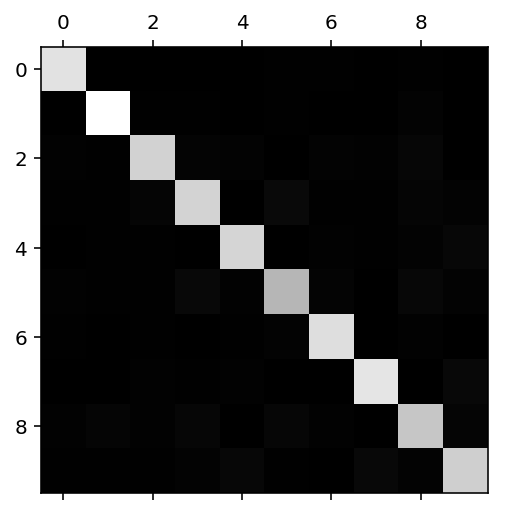

In [50]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

In [52]:
rows_sum=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / rows_sum

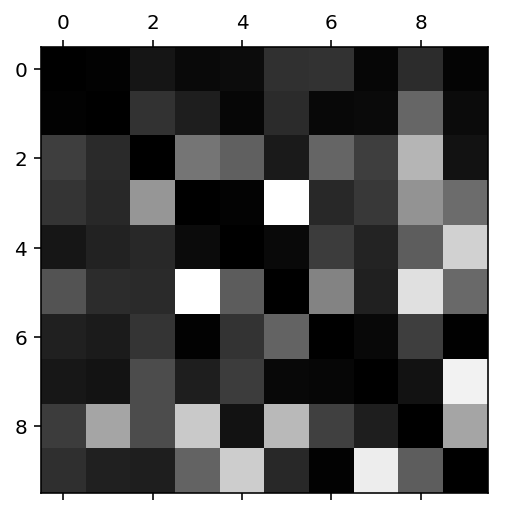

In [55]:
# 对中位数填充0,只关注错误
# 洞察错误发生错误的明显多的分类后，可以收集更多的训练集来进行优化
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

In [58]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a)  & (y_train_pred == cl_a) ]
X_ab = X_train[(y_train == cl_a)  & (y_train_pred == cl_b) ]
X_ba = X_train[(y_train == cl_b)  & (y_train_pred == cl_a) ]
X_bb = X_train[(y_train == cl_b)  & (y_train_pred == cl_b) ]

#### 多标签分类（Multilabel Classification）
##### 一个实例输出多个分类

In [59]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]
# knn支持多分类
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
#假定了所有的标签的权重都一样高，如果希望不同使用average="weight"
f1_score(y_train,y_train_knn_pred,average="macro")

#### 多输出分类（Multiouput Classification)
##### 它是上面的一个扩展
##### 略